<h1><center>Northeastern University</center></h1>
<h1><center>EECE 7150 Autonomous Field Robotics</center></h1>
<h1><center>HW4 Kalman Filter Submission</center></h1>
<h3><center>Yash Mewada</center></h3>
<h3><center>Date: Dec 2nd, 2023</center></h3>

This code was performed in collboration with my friend Rupesh Pathak, Hence some chunks of this assignment might resemble his code.

In [130]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pyproj import Proj, transform
from scipy.spatial.transform import Rotation as R
from scipy.signal import butter,filtfilt, detrend
from scipy import integrate
import tqdm
from test import KalmanFilter as kf
import math

GPS data: 3047
IMU data: 616323
This means that the IMU data is at 200hz where as the GPS data is at 1hz.

In [131]:
from numpy import dot, sum, tile, linalg 
from numpy.linalg import inv 
class Kalman_filter():
    def __init__(self,X,P):
        self.X = X
        self.P = P
        self.K = 0
    def predict(self, A, Q, B, U):
        self.X = dot(A, self.X) + dot(B, U)     
        self.P = dot(A, dot(self.P, A.T)) + Q     
        return(self.X,self.P)   
    
    def update(self, Y, H, R):     
        IM = dot(H, self.X)     
        IS = R + dot(H, dot(self.P, H.T))     
        self.K = dot(self.P, dot(H.T, inv(IS)))     
        self.X = self.X + dot(self.K, (Y-IM))     
        self.P = self.P - dot(self.K, dot(IS, self.K.T))         
        return (self.X,self.P,self.K)

In [132]:
class KalmanFilter:
    def __init__(self, gpsCsv, imuCsv):
        self.gpsCsv = gpsCsv
        self.imuCsv = imuCsv
        self.dt = 1.0 / 200

        # Initial conditions
        noise = 5.0
        self.x = np.array([0.0, 0.0, 0.0])
        self.P = np.eye(3) * 1e-4

        # State Transition Matrix
        self.F = np.array([[1, 0, self.dt], [0, 1, self.dt], [0, 0, 1]])

        # Control Input Matrix
        self.B = np.array([[0.5 * self.dt**2], [0.5 * self.dt**2], [self.dt]])

        # Measurement Matrix
        self.H = np.array(
            [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]]
        )  # Jacobian of observation function

        # Process Noise Covariance Matrix
        self.Q = np.eye(self.x.shape[0]) * noise**2

        # Measurement Noise Covariance Matrix
        fwdVelNoise = 0.3
        self.R = np.diag([fwdVelNoise**2, fwdVelNoise**2, noise**2])

        # constant velocity for IMU
        self.u = np.array([[0.1], [0.1]])
        self.KF = kf(self.x, self.P)

    def getImuData(self, field=None):
        if field == None:
            imuData = pd.read_csv(self.imuCsv)
            self.imutime = (
                imuData["header.stamp.secs"] - imuData["header.stamp.secs"][0]
            )
        else:
            imuData = pd.read_csv(self.imuCsv, usecols=[field])
        # print(self.imutime)

        return imuData

    def getGpsData(self, field=None):
        if field == None:
            gpsData = pd.read_csv(self.gpsCsv)
        else:
            gpsData = pd.read_csv(self.gpsCsv, usecols=[field])
        self.gpstime = gpsData["header.stamp.secs"] - gpsData["header.stamp.secs"][0]
        self.estimatedStates = np.zeros((len(self.gpstime), 3))
        self.estimatedMeasurements = np.zeros((len(self.gpstime), 2))
        # print(self.gpstime)
        selftrueStates = np.zeros((len(self.gpstime), 3))
        self.measurements = np.zeros((len(self.gpstime), 2))
        return gpsData

    def converttoUTM(self, gpsData):
        lat = gpsData["latitude"]
        long = gpsData["longitude"]
        myProj = Proj(proj="utm", zone="19", ellps="WGS84")
        self.utmX, self.utmY = myProj(long, lat)
        # print(self.utmX[0],self.utmY[0])
        return self.utmX, self.utmY

    def plotGPStraj(self, utmX, utmY):
        plt.plot(utmX, utmY, label="GPS Trajectory")
        plt.title("GPS Trajectory")
        plt.xlabel("UTM X")
        plt.ylabel("UTM Y")
        plt.legend()
        plt.show()

    def quaternionToEuler(self, x, y, z, w):
        r = R.from_quat([x, y, z, w])
        euler = r.as_euler("xyz")  # Assuming ZYX Euler angles
        yaw_z = euler[2]
        return yaw_z  # Extracting the third element (yaw/theta)

    def predict(self, xPrev, PPrev):
        # Predicted Step
        xPred = np.dot(self.F, xPrev) + np.dot(self.B, self.u.T)
        PPred = np.dot(self.F, np.dot(PPrev, self.F.T)) + self.Q
        return xPred, PPred

    def update(self, x_pred, P_pred, z):
        # Correction Step
        # K = P_pred @ self.H.T @ np.linalg.inv(self.H @ P_pred @ self.H.T + self.R)
        # x_corr = x_pred + K @ (z - self.H @ x_pred)
        # P_corr = (6 - K @ self.H) @ P_pred

        IM = np.dot(self.H, x_pred)
        IS = self.R + np.dot(self.H, np.dot(P_pred, self.H.T))
        self.K = np.dot(P_pred, np.dot(self.H.T, np.linalg.inv(IS)))
        x_corr = x_pred + np.dot(self.K, (z - IM))
        P_corr = P_pred - np.dot(self.K, np.dot(IS, self.K.T))
        # print("pred",x_corr)

        return x_corr, P_corr

    def converttoUTM(self, gps):
        c = 0
        utmX = []
        utmY = []
        lat = gps["latitude"]
        long = gps["longitude"]
        myProj = Proj(proj="utm", zone="19", ellps="WGS84")
        for i in range(len(lat)):
            if np.isnan(lat[i]) != True:
                utmx, utmy = myProj(long[i], lat[i])
                if c == 0:
                    iniX = utmx
                    iniY = utmy
                    c += 1
                utmX.append(utmx - iniX)
                utmY.append(utmy - iniY)
            else:
                utmX.append(long[i])
                utmY.append(lat[i])
        return np.array(utmX), np.array(utmY)

    def convertGpstoUTM(self, lat, long):
        myProj = Proj(proj="utm", zone="19", ellps="WGS84")
        utmX, utmY = myProj(long, lat)
        return np.array([utmX, utmY])

    def getyawBias(self):
        imuData = self.getImuData()
        imuX = imuData["orientation.x"]
        imuY = imuData["orientation.y"]
        imuZ = imuData["orientation.z"]
        imuW = imuData["orientation.w"]
        self.yaw = []

        for i in range(len(imuX)):
            self.yaw.append(self.quaternionToEuler(imuX[i], imuY[i], imuZ[i], imuW[i]))
        self.yaw = np.array(self.yaw)
        Bias = np.mean(self.yaw[:54700])
        self.yaw = self.yaw - Bias
        return self.yaw

    def getangVel(self):
        imuData = self.getImuData()
        angZ = imuData["angular_velocity.z"][:2735].to_numpy()
        bias = np.mean(angZ)
        yawrate = imuData["angular_velocity.z"] - bias

        plt.plot(yawrate, label="Yaw Rate")
        plt.title("Yaw Rate estimate from Gyro")
        plt.xlabel("Time")
        plt.ylabel("Yaw Rate")
        plt.legend()
        plt.show()

        return yawrate

    def runKF(self):
        # store the estimated states and measurements for plotting

        gpsData = self.getGpsData()
        gpslat = gpsData["latitude"]
        gpslong = gpsData["longitude"]
        imuData = self.getImuData()
        imuX = imuData["orientation.x"]
        imuY = imuData["orientation.y"]
        imuZ = imuData["orientation.z"]
        imuW = imuData["orientation.w"]

        imuidx = 0
        imuFreq = 200
        gpsFreq = 1
        yaw = []
        xkf, ykf, thetakf = [], [], []
        dt = (
            imuData["header.stamp.nsecs"][1] - imuData["header.stamp.nsecs"][0]
        ) / 10_000_000_000
        vel = self.estVel()
        yawRate = self.getangVel()
        imuData = self.getImuData()
        yaw = self.getyawBias()
        k, c = 0, 0
        gpdbias = 30758

        X = np.array([0, 0, 0])
        P = np.eye(3) * 1e-4
        my_kf = Kalman_filter(X, P)
        A = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
        Q = np.eye(X.shape[0]) * 1e-4
        R = np.eye(X.shape[0]) * 1e-2

        for i in range(len(vel)):
            v = vel[i]
            theta = yawRate[i]
            t = imuData["header.stamp.secs"][i]
            if theta == 0:
                self.B = np.array([dt * np.cos(self.x[2]), dt * np.sin(self.x[2]), 0])
                self.u = np.array([v])
                self.x, self.P = self.predict(self.x, self.P)

            else:
                self.B = np.array(
                    [
                        [
                            (np.sin(self.x[2] + theta * dt) - np.sin(self.x[2]))
                            / theta,
                            0,
                        ],
                        [
                            (np.cos(self.x[2]) - np.cos(self.x[2] + theta * dt))
                            / theta,
                            0,
                        ],
                        [0, dt],
                    ]
                )
                self.u = np.array([v, theta])
                self.x, self.P = self.predict(self.x, self.P)

            if k < gpdbias:
                utmx, utmy = self.convertGpstoUTM(gpslat[k], gpslong[k])
                if c != 20:
                    if np.isnan(utmx) == False and np.isnan(utmy) == False:
                        z = np.array([utmx, utmy, yaw[i]])
                        self.H = np.eye(3)
                        self.x, self.P = self.update(self.x, self.P, z)
                else:
                    if np.isnan(utmx) == False and np.isnan(utmy) == False:
                        z = np.array([utmx, utmy, yaw[k]])
                        self.H = np.eye(3)
                        self.x, self.P = self.update(self.x, self.P, z)
                    k += 1
                    c = 0
            c += 1
            xkf.append(self.x[0])
            ykf.append(self.x[1])
            thetakf.append(self.x[2])

        plt.plot(xkf, ykf, label="Kalman Filter Trajectory")
        plt.plot(self.utmX, self.utmY, label="GPS Trajectory")
        plt.title("Kalman Filter Trajectory")
        plt.xlabel("X Position")
        plt.ylabel("Y Position")
        plt.legend()
        plt.show()

    def estVel(self):
        imuData = self.getImuData()
        linX = imuData["linear_acceleration.x"][:54700].to_numpy()
        linXBias = np.mean(linX)
        linX = imuData["linear_acceleration.x"] - linXBias

        linY = imuData["linear_acceleration.y"][:54700].to_numpy()
        linYBias = np.mean(linY)
        linY = imuData["linear_acceleration.y"] - linYBias

        delta_t = (
            imuData["header.stamp.nsecs"][1] - imuData["header.stamp.nsecs"][0]
        ) / 10_000_000_000
        velocity_x = np.cumsum(linX) * delta_t
        velocity_y = np.cumsum(linY) * delta_t

        resVel = np.sqrt(velocity_x**2 + velocity_y**2)

        plt.plot(resVel, label="Resulant Velocity")
        plt.plot(velocity_x, label="Estimated Velocity X")
        plt.plot(velocity_y, label="Estimated Velocity Y")
        plt.xlabel("Time")
        plt.ylabel("Velocity m/s")
        plt.legend()
        plt.show()

        return velocity_x

    def testKF(self):
        import seaborn

        X_kf = []
        Y_kf = []
        Theta_kf = []

        imu = self.getImuData()
        dt = (
            imu["header.stamp.nsecs"][1] - imu["header.stamp.nsecs"][0]
        ) / 10_000_000_000

        # Initialization of state matrices
        X = np.array([0, 0, 0])
        P = np.eye(3) * 1e-4
        my_kf = Kalman_filter(X, P)
        A = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
        Q = np.eye(X.shape[0]) * 1e-4
        R = np.eye(X.shape[0]) * 1e-2
        c = 0
        k = 0
        velocity = self.estVel()
        yaw_rate = self.getangVel()
        dist_x, dist_y = self.converttoUTM(self.getGpsData())
        yaw = self.getyawBias()
        # Applying the Kalman Filter
        for i in range(len(velocity)):
            v = velocity[i]
            theta = yaw_rate[i]
            time = imu["header.stamp.secs"][i]
            if theta == 0:
                B = np.array([dt * np.cos(X[2]), dt * np.sin(X[2]), 0])
                U = np.array([v])
                (X, P) = my_kf.predict(A, Q, B, U)
            else:
                B = np.array(
                    [
                        [(np.sin(X[2] + theta * dt) - np.sin(X[2])) / theta, 0],
                        [(np.cos(X[2]) - np.cos(X[2] + theta * dt)) / theta, 0],
                        [0, dt],
                    ]
                )
                U = np.array([v, theta])
                (X, P) = my_kf.predict(A, Q, B, U)

            if k < 30758:
                if c != 20:
                    if np.isnan(dist_x[k]) == False and np.isnan(dist_y[k]) == False:
                        Y = np.array([dist_x[k], dist_y[k], yaw[i]])
                        H = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
                        (X, P, K) = my_kf.update(Y, H, R)
                else:
                    if np.isnan(dist_x[k]) == False and np.isnan(dist_y[k]) == False:
                        Y = np.array([dist_x[k], dist_y[k], yaw[i]])
                        H = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
                        (X, P, K) = my_kf.update(Y, H, R)
                    k += 1
                    c = 0
            c += 1
            X_kf.append(X[0])
            Y_kf.append(X[1])
            Theta_kf.append(X[2])

        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        seaborn.scatterplot(y=Y_kf, x=X_kf, label="KF")
        plt.plot(X_kf, Y_kf)
        seaborn.scatterplot(y=dist_y, x=dist_x, label="gps")
        plt.plot(dist_x, dist_y)
        ax.set_xlabel("X Position")
        ax.set_ylabel("Y Position")
        plt.title("Estimated path")
        plt.legend()

    def estTraj(self):
        imuData = self.getImuData()
        imuX = imuData["orientation.x"]
        imuY = imuData["orientation.y"]
        imuZ = imuData["orientation.z"]
        imuW = imuData["orientation.w"]

        Vn = []
        Ve = []
        fwdVel = self.estVel()
        for i in range(len(imuX)):
            fv = fwdVel[i]
            yaw = self.quaternionToEuler(imuX[i], imuY[i], imuZ[i], imuW[i])
            Vn.append(np.cos(yaw) * fv - np.sin(yaw) * fv)
            Ve.append(np.sin(yaw) * fv + np.cos(yaw) * fv)

        Xe = np.zeros_like(Ve)
        Xe[0] = Ve[0]
        Xe[1:] = integrate.cumtrapz(Ve, dx=1 / 200)
        Xe /= 3

        Xn = np.zeros_like(Vn)
        Xn[0] = Vn[0]
        Xn[1:] = integrate.cumtrapz(Vn, dx=1 / 200)
        Xn /= 3

        plt.plot(Xe, Xn, label="Estimated Trajectory")
        plt.title("Estimated Trajectory")
        plt.xlabel("X Position")
        plt.ylabel("Y Position")
        plt.legend()
        plt.show()

        plt.plot(fwdVel, label="Estimated Velocity")
        plt.title("Estimated Velocity")
        plt.xlabel("Time")
        plt.ylabel("Velocity")
        plt.legend()
        plt.show()

        return Xe, Xn

    def gen_xy_from_yaw(self, yaw, dt, v0):
        psi0 = -np.pi / 2 + yaw[0]
        psiR = yaw
        dxdt = v0 * np.sin(psi0 - psiR)
        dydt = v0 * np.cos(psi0 - psiR)
        x = (dt * dxdt).cumsum()
        y = (dt * dydt).cumsum()
        return x, y

    def normalize_angles(self, angles):
        """
        Args:
            angles (float or numpy.array): angles in radian (= [a1, a2, ...], shape of [n,])
        Returns:
            numpy.array or float: angles in radians normalized b/w/ -pi and +pi (same shape w/ angles)
        """
        angles = (angles + np.pi) % (2 * np.pi) - np.pi
        return angles

    def deadReckoning(self):
        x, y, theta = 0, 0, 0

        ximu, yimu, thetaimu = [], [], []
        vel = self.estVel()
        yawRate = self.getangVel()
        imuData = self.getImuData()
        yaw = self.getyawBias()
        dt = 1 / 200
        for i in range(len(vel)):
            v = vel[i]
            theta = yawRate[i]
            x0 = x
            y0 = y
            theta0 = theta
            if theta == 0:
                x = x0 + v * dt * np.cos(theta0)
                y = y0 + v * dt * np.sin(theta0)
                theta = theta0
                # ximu.append(x)
                # yimu.append(y)
                # thetaimu.append(theta)
            else:
                x = x0 + v * (np.sin(theta0 + theta * dt) - np.sin(theta0)) / theta
                y = y0 + v * (np.cos(theta0) - np.cos(theta0 + theta * dt)) / theta
                theta = theta0 + theta * dt
                ximu.append(x)
                yimu.append(y)
                thetaimu.append(theta)

        plt.plot(ximu, yimu, label="Dead Reckoning Trajectory")
        plt.xlabel("X Position")
        plt.ylabel("Y Position")
        plt.legend()
        plt.show()

        plt.plot(thetaimu, label="Dead Reckoning Theta")
        plt.plot(yaw, label="IMU Theta")
        plt.xlabel("Time")
        plt.ylabel("Theta")
        plt.legend()
    

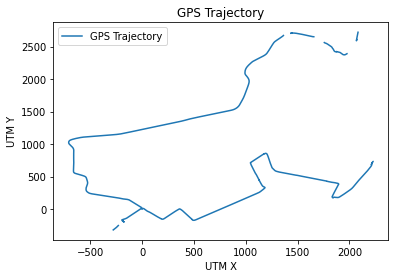

[-0.05013284 -0.05013002 -0.05013377 ... -0.04593024 -0.04592308
 -0.0459206 ]


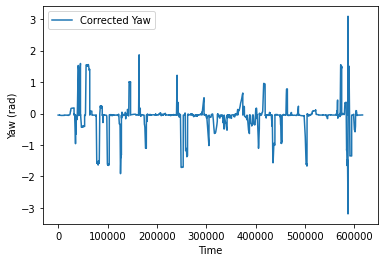

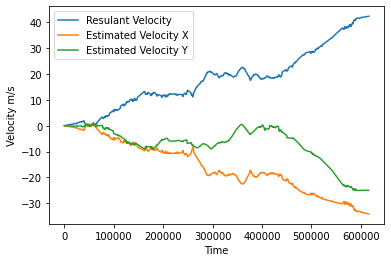

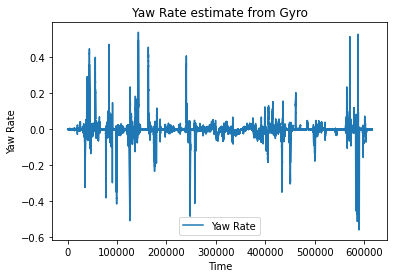

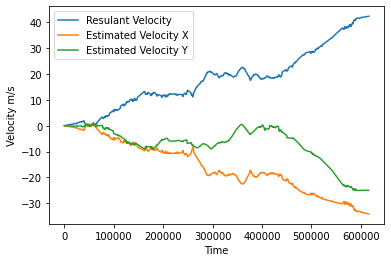

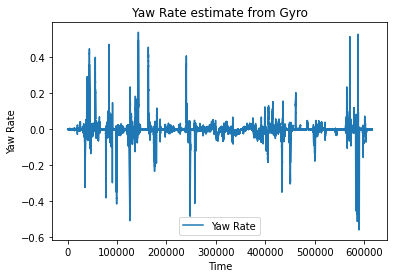

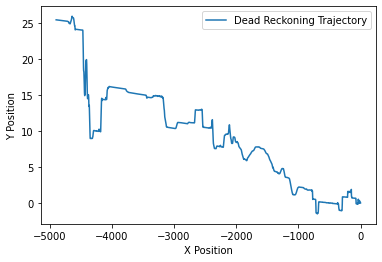

/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


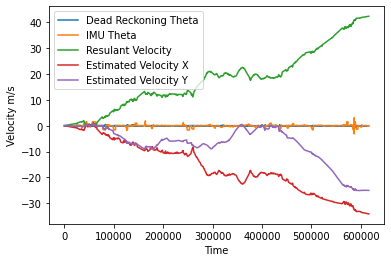

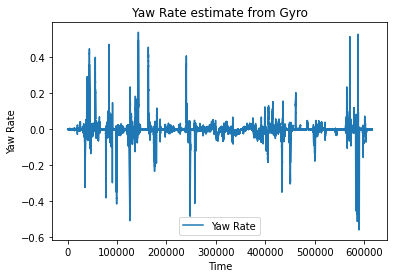

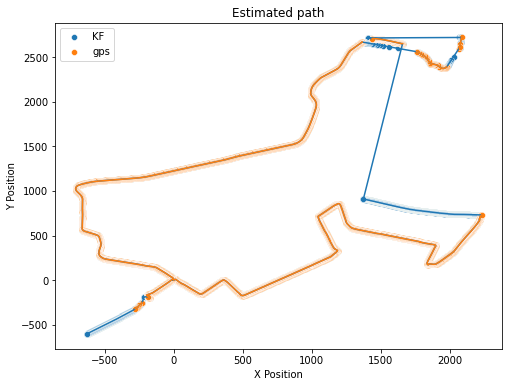

In [133]:
if __name__ == "__main__":
    gpscsv = '/home/mewada/Documents/AFR/CSV_data/gps-fix.csv'
    imucsv = '/home/mewada/Documents/AFR/CSV_data/imu-imu_uncompensated.csv'
    kf = KalmanFilter(gpscsv,imucsv)
    kf.plotGPStraj(kf.converttoUTM(kf.getGpsData())[0],kf.converttoUTM(kf.getGpsData())[1])
    
    corrYaw = kf.getyawBias()
    print(corrYaw)
    plt.plot(corrYaw,label="Corrected Yaw")
    plt.xlabel("Time")
    plt.ylabel("Yaw (rad)")
    plt.legend()
    plt.show()
    
    kf.estVel()
    
    yawrate = kf.getangVel()
    kf.deadReckoning()
    kf.testKF()